In [1]:

import pandas as pd
from speechbrain.nnet.pooling import StatisticsPooling
from prepare import WaveformEncoder
import numpy as np

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/data/at_states'
source_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb/10006/save/CKPT+2024-10-03+11-03-55+00/embedding_model.ckpt'
hparams_path = '/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb/10006/hyperparams.yaml'

# MMS embedding

In [3]:
from transformers import Wav2Vec2ForSequenceClassification, AutoFeatureExtractor
import torch
import soundfile as sf

# Load the model and processor once
model_id_mms = "facebook/mms-lid-4017"
processor_mms = AutoFeatureExtractor.from_pretrained(model_id_mms)
model_mms = Wav2Vec2ForSequenceClassification.from_pretrained(model_id_mms)

def get_embedding_mms(audio_file, model, processor):
    # Load audio file
    speech, sample_rate = sf.read(audio_file)

    # Process the audio using the feature extractor
    # if stereo, use only one channel
    if len(speech.shape) > 1:
        speech = speech[:, 0]
    inputs = processor(speech, sampling_rate=sample_rate, return_tensors="pt", padding=True)

    # Forward pass through the model to get both logits and hidden states
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    # Extract the logits for language identification
    logits = outputs.logits

    # Get the predicted language
    lang_id = torch.argmax(logits, dim=-1)[0].item()
    detected_lang = model.config.id2label[lang_id]

    # Extract the embeddings from the last hidden state
    embeddings = outputs.hidden_states[-1]

    # Optionally, calculate mean embeddings if you need a single vector per input
    mean_embeddings = torch.mean(embeddings, dim=1)

    # Return the detected language and embeddings
    return detected_lang, mean_embeddings

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at facebook/mms-lid-4017 were not used when initializing Wav2Vec2ForSequenceClassification: ['wav2vec2.encoder.layers.7.adapter_layer.linear_2.bias', 'wav2vec2.encoder.layers.41.adapter_layer.linear_2.bias', 'wav2vec2.encoder.layers.40.adapter_layer.linear_1.weight', 'wav2vec2.encoder.layers.8.adapter_layer.linear_1.weight', 'wav2vec2.encoder.layers.47.adapter_layer.norm.weight', 'wav2vec2.encoder.layers.25.adapter_layer.norm.bias', 'wav2vec2.encoder.layers.12.adapter_layer.linear_2.weight', 'wav2vec2.encoder.layers.38.adapter_layer.linear_2.weight', 'wav2vec2.encoder.layers.35.adapter_layer.linear_1.bias', 'wav2vec2.encoder.layers.26.adapter_lay

In [4]:
# Usage of the function
audio_file = "/home/projects/vokquant/fairseq/audio_samples/de.wav"  # Path to the audio file

detected_language, embeddings = get_embedding_mms(audio_file, model_mms, processor_mms)

print(f"Detected language: {detected_language}")
print("Embeddings shape:", embeddings.shape)

Detected language: deu
Embeddings shape: torch.Size([1, 1280])


# MMS compute embs

In [8]:
import os
from tqdm import tqdm
import pickle

# read test items
test_items = pd.read_csv(f'{test_path}/test.csv')
embeddings_mms = []
accents = []

output_folder = "/home/projects/vokquant/accent-recog-slt2022/CommonAccent/results/ECAPA-TDNN/AT/spkrec-ecapa-voxceleb"
save_path = os.path.join(output_folder, "embeddings")

# go through all test items and get embeddings
for index, row in tqdm(test_items.iterrows()):
    if index % 10 != 0:
        continue
    else:
        # filepath = f"{test_path}/test/{row['utt_id']}.wav"
        filepath = f"{row['wav']}"
        filename = test_items.iloc[index].utt_id #filepath.split("/")[-1].replace(".wav", ".npy").replace(".mp3", ".npy")
        lang, emb_mms = get_embedding_mms(filepath, model_mms, processor_mms)    
        accent = row['accent']
        embeddings_mms.append(emb_mms)
        accents.append(accent)

embeddings_mms = [emb.numpy() for emb in embeddings_mms]

with open(os.path.join("/home/projects/vokquant/accent-recog-slt2022/notebooks/pickle_files", "embeddings_mms.pkl"), "wb") as f:
    pickle.dump(embeddings_mms, f)

# embeddings_mms = np.array(embeddings_mms)
print("Embeddings shape: ", np.shape(embeddings_mms))
print("Accents shape: ", np.shape(accents))

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2035: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = asarray(a).shape


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (260,) + inhomogeneous part.

In [14]:
print((embeddings_mms))
# make each tensor to numpy array


[tensor([[ 0.8310, -0.6110, -0.5718,  ..., -0.3967, -0.7620, -0.1645]]), tensor([[ 0.4585,  0.2975, -0.3038,  ..., -0.4901, -1.3737,  0.1783]]), tensor([[ 0.4983,  0.2603, -0.2459,  ..., -0.4645, -1.0204,  0.8177]]), tensor([[ 1.5102,  0.0585, -0.7733,  ..., -0.5686,  0.2620,  0.8546]]), tensor([[ 0.1845, -0.1615, -0.2160,  ..., -0.0873, -1.0490,  0.1612]]), tensor([[ 0.5374,  0.1583, -0.2416,  ..., -0.4235, -0.8497,  0.8717]]), tensor([[ 0.1835,  1.1796, -0.0641,  ..., -0.6207, -1.7821,  1.2246]]), tensor([[ 1.2322, -0.5461, -0.7657,  ..., -0.8850, -0.3184,  0.7327]]), tensor([[ 0.5918,  0.4313, -0.3851,  ..., -0.1790, -1.0481,  0.3805]]), tensor([[ 1.2690, -0.3193, -0.3175,  ..., -0.5220, -0.1303,  1.1305]]), tensor([[ 1.3913e+00, -4.0115e-01, -8.0028e-01,  ..., -6.0670e-01,
         -8.2510e-04,  9.8176e-01]]), tensor([[ 0.5512, -0.5434, -0.4005,  ..., -0.1616, -0.2650,  1.1734]]), tensor([[-0.3959, -0.7470, -0.1667,  ...,  0.0152, -0.6976,  1.0043]]), tensor([[ 0.0333, -0.2628,  0.

In [16]:
# array = []
# for x in embeddings_mms:
#     print(x[1].shape)
#     array.append(x[1])
embeddings_mms2 = np.array([x for x in embeddings_mms])
# print(embeddings_mms2)
# print(embeddings_mms[0][1].shape)
# embeddings_mms2 = embeddings_mms[:, 1]

# embeddings_mms2 = np.array(embeddings_mms2)
print("Embeddings shape: ", np.shape(embeddings_mms2))
print("Accents shape: ", np.shape(accents))

# squeeze middle dimension
embeddings_mms3 = np.squeeze(embeddings_mms2, axis=1)
print("Embeddings shape: ", np.shape(embeddings_mms3))

Embeddings shape:  (260, 1, 1280)
Accents shape:  (260,)
Embeddings shape:  (260, 1280)


# MMS visualization

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Define a dictionary to store embeddings for each class
emb_dict = {cls: [] for cls in np.unique(accents)}

# Fill the dictionary with embeddings
for accent, emb in zip(accents, embeddings_mms3):
    emb_dict[accent].append(emb)

# Convert the dictionary values to numpy arrays
for cls in emb_dict:
    emb_dict[cls] = np.array(emb_dict[cls])

# Create labels for each class
label_dict = {cls: i*np.ones(len(emb_dict[cls])) for i, cls in enumerate(emb_dict)}

# Concatenate embeddings and labels
X = np.concatenate(list(emb_dict.values()))
y = np.concatenate(list(label_dict.values()))

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


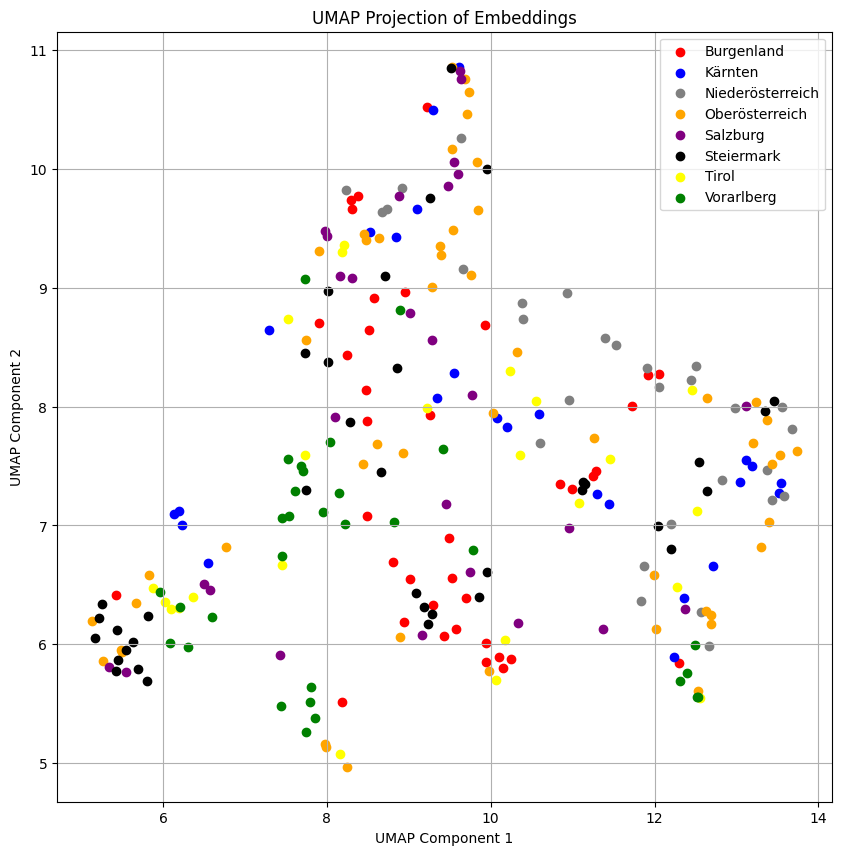

In [20]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Instantiate UMAP
umap_model = umap.UMAP(n_components=2, random_state=0)
X_embedded_umap = umap_model.fit_transform(X)

classes = ['Burgenland', 'Kärnten', 'Niederösterreich', 'Oberösterreich', 'Salzburg', 'Steiermark', 'Tirol', 'Vorarlberg']

# Define marker styles
markers = ['o', 's', 'D', '^', 'v', 'P', '*', 'X']  # Circle, square, diamond, triangle up, triangle down, plus, star, X
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']

# Plot the embeddings
plt.figure(figsize=(8, 8))
for i, (cls, embeddings_mms3) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded_umap[y == i, 0], X_embedded_umap[y == i, 1], 
                c=colors[i], label=classes[i], 
                # marker=markers[i % len(markers)],  # Use different markers
                # alpha=0.6,  # Add transparency
                # edgecolor='k',
                )  # Add a black edge color for better visibility

plt.title('UMAP Projection of Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)  # Add a grid for better readability
plt.show()

/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lorenzg/miniconda3/envs/dicla/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


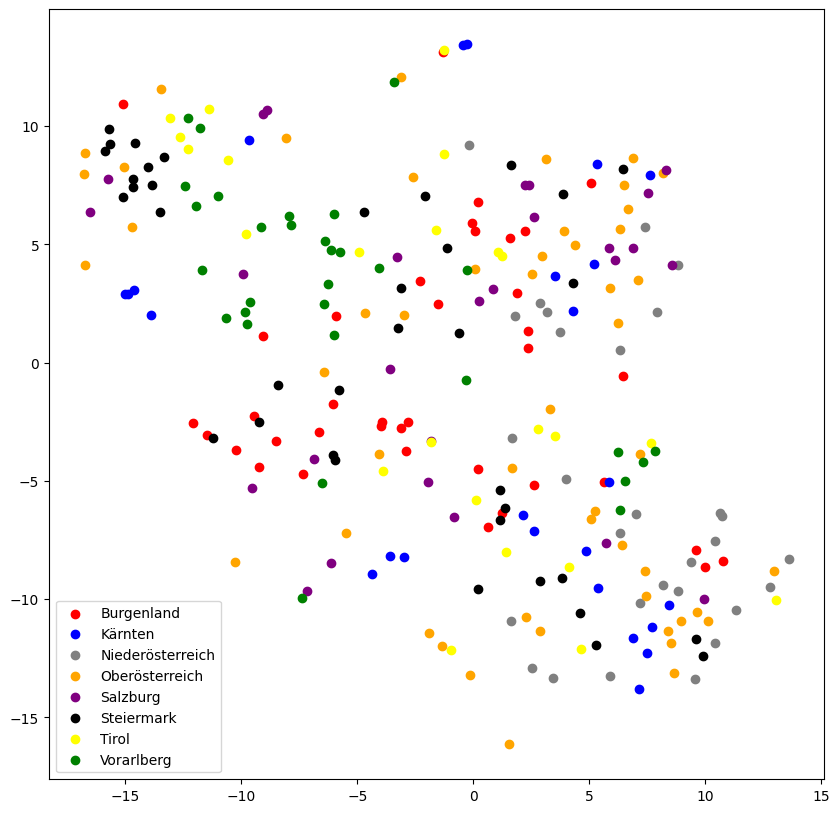

In [21]:
# make for tsne
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

# Plot the embeddings
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'grey', 'orange', 'purple', 'black', 'yellow', 'green']
for i, (cls, emb) in enumerate(emb_dict.items()):
    plt.scatter(X_embedded[y == i, 0], X_embedded[y == i, 1], c=colors[i], label=classes[i])  # Use classes[i] as label

# Add the legend with class names
plt.legend()
plt.show()

